In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
# Load CSV file
csv_path = 'archive\dogs.csv'
df = pd.read_csv(csv_path)
selected_breeds = ['Afghan','Border Collie','Corgi', 'Coyote','Doberman', 'German Sheperd', 'Labradoodle','Maltese', 'Pomeranian','Pug','Rottweiler', 'Saint Bernard','Shiba Inu','Shih-Tzu', 'Siberian Husky']

train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

train_df = train_df[train_df['labels'].isin(selected_breeds)]
valid_df = valid_df[valid_df['labels'].isin(selected_breeds)]
test_df = test_df[test_df['labels'].isin(selected_breeds)]

In [4]:
img_size = (224, 224)
batch_size = 32

# Create image data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='archive/',
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1728 validated image filenames belonging to 15 classes.
Found 150 validated image filenames belonging to 15 classes.
Found 150 validated image filenames belonging to 15 classes.


In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(15, activation='softmax')
])

In [16]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15
)

Epoch 1/15
54/54 [==============================] - 10s 173ms/step - loss: 1.1110 - accuracy: 0.5677 - val_loss: 0.4717 - val_accuracy: 0.8600
Epoch 2/15
54/54 [==============================] - 9s 168ms/step - loss: 1.0662 - accuracy: 0.5851 - val_loss: 0.4540 - val_accuracy: 0.8933
Epoch 3/15
54/54 [==============================] - 9s 167ms/step - loss: 1.0388 - accuracy: 0.6186 - val_loss: 0.4009 - val_accuracy: 0.8933
Epoch 4/15
54/54 [==============================] - 9s 167ms/step - loss: 1.0282 - accuracy: 0.6100 - val_loss: 0.4302 - val_accuracy: 0.9000
Epoch 5/15
54/54 [==============================] - 9s 166ms/step - loss: 1.0228 - accuracy: 0.6036 - val_loss: 0.4810 - val_accuracy: 0.8200
Epoch 6/15
54/54 [==============================] - 9s 166ms/step - loss: 0.9896 - accuracy: 0.6279 - val_loss: 0.4177 - val_accuracy: 0.8800
Epoch 7/15
54/54 [==============================] - 9s 167ms/step - loss: 1.0619 - accuracy: 0.6030 - val_loss: 0.3848 - val_accuracy: 0.8867
Epoch

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

5/5 [==============================] - 1s 67ms/step - loss: 0.4940 - accuracy: 0.8467
Test Accuracy: 0.846666693687439


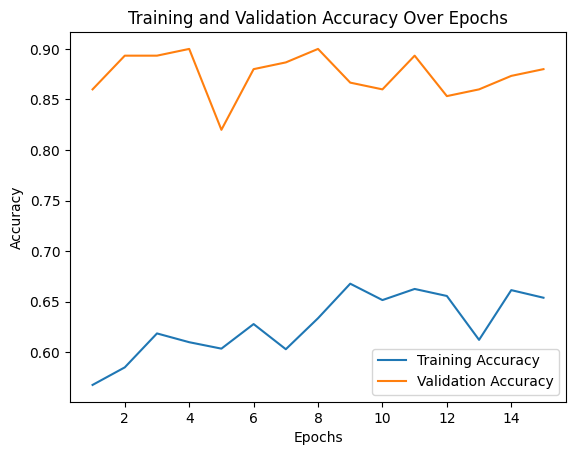

In [19]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy over epochs
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

img_path = 'archive\\test\German Sheperd\\06.jpg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


In [21]:
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
class_labels = train_generator.class_indices
predicted_class_label = [k for k, v in class_labels.items() if v == predicted_class_index][0]



1/1 [==============================] - 1s 800ms/step


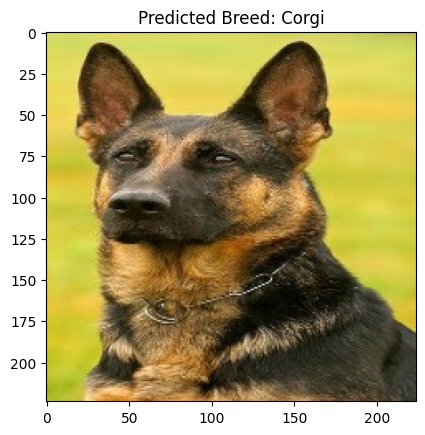

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f'Predicted Breed: {predicted_class_label}')
plt.show()


In [ ]:
model.save("dog_breed_model.h5")
